# Linear regression in PyTorch

## Goal

Here we fit a linear map
$x\mapsto y=b+mx$
to a cloud of data $\{(x_1, y_1), \dots, (x_N, y_N)\}$ by successive approximations using linear maps
$$ y = b^{(n)} + m^{(n)}x\qquad n=1, 2, \dots, N\,.$$
For comparison, we plot the linear regression derived analytically in `Scikit-Learn`.


In other notebooks we have implemented linear regression with minimal sets of PyTorch features.  In this notebook, we implement the full workflow as it is used more generally in deep learning.


## References
- [PyTorch: Linear and Logistic Regression Models](https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9) (Andrea Eunbee Jang, Medium)
- [PyTorch's `torch.nn.MSELoss` class](https://pytorch.org/docs/stable/nn.html#mseloss) (pytorch documentation)
- [PyTorch's `torch.nn.Module.train()` method](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train) (pytorch documentation)
- [PyTorch's `torch.nn.Module.state_dict()` method](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.state_dict) (pytorch documentation)

---
tags: pytorch, tutorial, linear regression, dataloader, gradient descent, mini batch gradient descent, optimizer, module

# Imports

In [1]:
from sklearn.linear_model import LinearRegression # for comparison
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# Data
*Remark*.  No need for dataloaders **yet** for classical gradient descent.

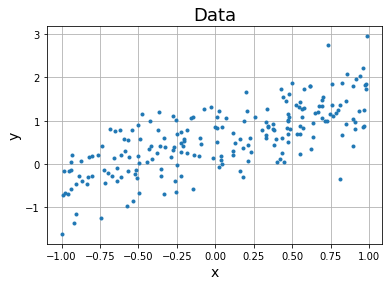

In [2]:
# Number of samples
n_batches = 2**2
batch_size = 2**6
N = (n_batches - 1)*batch_size + batch_size//4 # size of dataset

# Samples
x = (-1 + 2*torch.rand(1, N)).view(-1, 1)
sigma = .5
h = sigma*torch.randn(1, N).view(-1, 1)
targs = .5 + x + h

# Visualization
plt.plot(x, targs,'.');
plt.xlabel("x",  fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Data", fontsize=18)
plt.grid();

# Ordinary least squares linear regression with `Scikit-Learn`
Calculate the linear regressor using closed form using `sklearn`:

In [3]:
linreg = LinearRegression()
linreg.fit(x, targs)

preds_lms = linreg.predict(x)
loss_lms = (targs.numpy()**2- preds_lms**2).mean()
print(f"{'Slope':<10} m={linreg.coef_[0,0]:.4f}")
print(f"{'Intercept':<10} b={linreg.intercept_[0]:.4f}")
print(f"{'Loss':<10} L={loss_lms:.4f}")

Slope      m=0.9389
Intercept  b=0.5518
Loss       L=0.2698


# Custom `LinearRegressor` class

In [4]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        y = self.linear(x)
        return y

# Instantiate model

In [5]:
model = LinearRegressor()

Remark: by default, `Module`s are set in training mode, otherwise enforced with `model.train()`:
>Sets the module in training mode.
>
>This has any effect only on certain modules. See documentations of particular modules for details of their behaviors in training/evaluation mode, if they are affected, e.g. Dropout, BatchNorm, etc.

This can be verified in the `training` attribute:

In [6]:
model.training

True

We can view the state of our `model` as a dictionary:

In [7]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1956]])),
             ('linear.bias', tensor([-0.6042]))])

# Criterion: the loss function

In [8]:
criterion = nn.MSELoss(reduction='mean')

# Learning rate

In [9]:
lr = .02

# Optimizer

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train with (batch/classical) gradient descent

In [11]:
losses = []
weights = []
biases = []

In [12]:
n_epochs = 50

for epoch in range(n_epochs):
    model.train() # does not do anything in this simple case
    preds = model.forward(x)
    loss = criterion(preds, targs)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.item())
    weights.append(model.linear.weight.item())
    biases.append(model.linear.bias.item())

# Loss during training

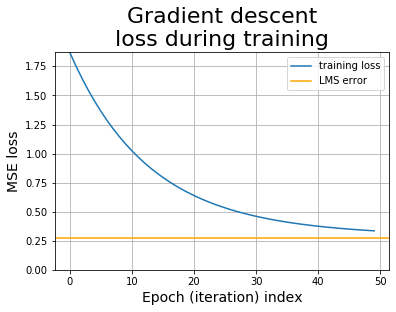

In [13]:
fig, ax = plt.subplots()
ax.plot(losses, label='training loss');
ax.axhline(loss_lms, color='Orange', label='LMS error')
ax.set_ylim([0, min(max(losses), 10*loss_lms)])
ax.legend();
ax.set_xlabel("Epoch (iteration) index", fontsize=14)
ax.set_ylabel("MSE loss", fontsize=14)
ax.set_title("Gradient descent\nloss during training", fontsize=22)
ax.grid();

# Successive approximations

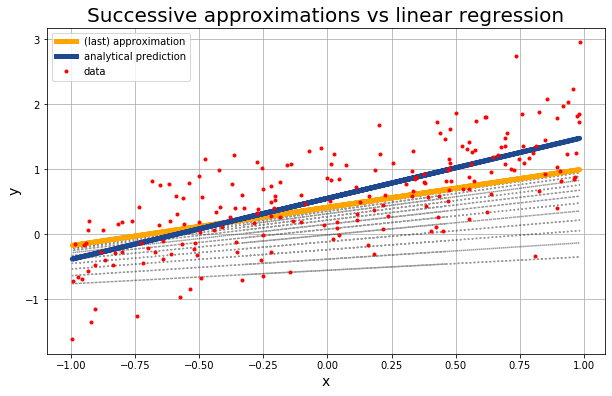

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

for w, b in zip(weights[::n_batches], biases[::n_batches]):
    preds = w*x+b
    
    ax.plot(x, preds.detach().numpy(), 'k:', alpha=.4)
ax.plot(x, preds.detach().numpy(), 'Orange', label='(last) approximation', linewidth=5) # last iteration
ax.plot(x, preds_lms, 'xkcd:cobalt', label='analytical prediction', linewidth=5)
ax.plot(x, targs, linestyle='', marker='.', color='r', label='data');

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title("Successive approximations vs linear regression", fontsize=20);
ax.legend();
ax.grid();

# Mini-batch gradient descent
# Dataloader

In [15]:
ds = TensorDataset(x, targs)
dl = DataLoader(ds, batch_size, shuffle=False)

Re-initialize objects:

In [16]:
model = LinearRegressor()
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Train with mini-batch gradient descent

In [17]:
losses = []
weights = []
biases = []

n_epochs = 10

for epoch in range(n_epochs):
    for x_b, targs_b in dl:
        preds_b = model(x_b)
        loss_b = criterion(preds_b, targs_b)
        loss_b.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            preds = model(x)
            loss = criterion(preds, targs)

        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())
        losses.append(loss.item())

# Successive losses

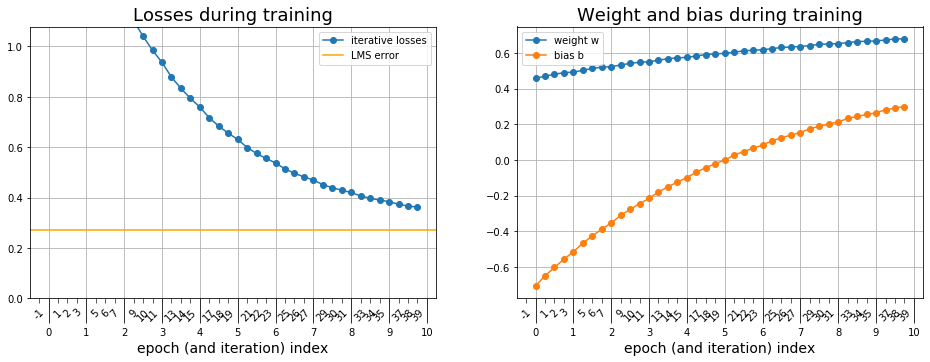

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
ax.plot(losses, 'o-', label='iterative losses')
ax.axhline(loss_lms, color='Orange', label='LMS error')
ax.grid();
ax.legend();
ax.set_xlabel("iteration index", fontsize=14);
ax.set_title("Losses during training", fontsize=18);
# ax.set_ylim([0, max(losses).item() + 1]);
ax.set_ylim(0, min(4*loss_lms, max(losses) + 1))

ax = axs[1]

ax.plot(weights, 'o-', label='weight w')
ax.plot(biases, 'o-', label='bias b')
ax.grid();
ax.legend();
ax.set_title("Weight and bias during training", fontsize=18);

for ax in axs:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(n_batches))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(n_batches//4))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{t//n_batches:.0f}"))
    ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda t, pos: f"{t:.0f}"))
    ax.tick_params(which='major', axis='x', length=25)
    ax.tick_params(which='minor', labelrotation=45, length=5)
    ax.set_xlabel("epoch (and iteration) index", fontsize=14);

# Successive approximations

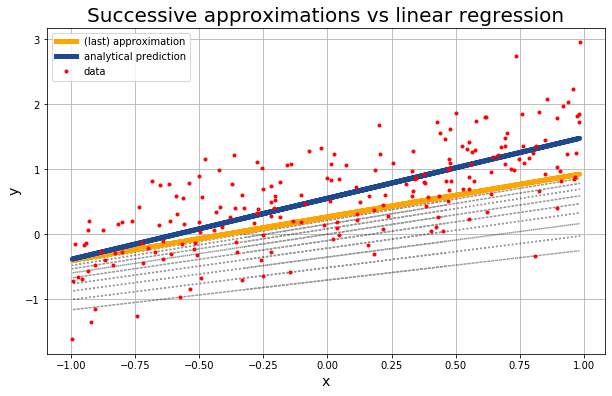

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

for w, b in zip(weights[::n_batches], biases[::n_batches]):
    preds = w*x+b
    
    ax.plot(x, preds.detach().numpy(), 'k:', alpha=.4)
ax.plot(x, preds.detach().numpy(), 'Orange', label='(last) approximation', linewidth=5) # last iteration
ax.plot(x, preds_lms, 'xkcd:cobalt', label='analytical prediction', linewidth=5)
ax.plot(x, targs, linestyle='', marker='.', color='r', label='data');

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title("Successive approximations vs linear regression", fontsize=20);
ax.legend();
ax.grid();